In [1]:
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_size = 256

In [3]:
def plot_images(images):
    plt.figure(figsize = (50 * 3, 50))
    num_images = images.shape[0]
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [4]:
def preprocessing_function(image):
        image = image.astype(float) / 255.
        return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
image_iterator = idg.flow_from_directory(
    '../../heightmaps/uncorrupted_split_heightmaps_second_pass/',
    target_size = (image_size, image_size),
    batch_size = 1,
    color_mode = 'grayscale',
    shuffle = True,
    classes = ['']
)

Found 582569 images belonging to 1 classes.


In [5]:
class UpSampleGaussianBlur(keras.models.Model):
    def __init__(self, kernel_size=8, sigma=0.5):
        super().__init__()
        self.kernel_size = kernel_size
        self.kernel_weights = self.get_kernel(shape=(kernel_size, kernel_size), sigma=sigma)
        self.kernel_weights = np.repeat(self.kernel_weights, 1, axis=-1)
        self.kernel_weights = np.expand_dims(self.kernel_weights, axis=-1)
        self.model = self.get_model()
        
    def get_model(self):
        inputs = layers.Input(shape=(image_size, image_size, 1))
        x = layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(inputs)
        #x = layers.DepthwiseConv2D(self.kernel_size, use_bias=False, padding='same')(x)
        model = keras.Model(inputs, x)
        #model.layers[2].set_weights = self.kernel_weights
        return keras.Model(inputs, x)
    
    def call(self, x):
        return self.model(x)
        
    def get_kernel(self, shape=(3, 3), sigma=0.5):
        m,n = [(ss-1.)/2. for ss in shape]
        y,x = np.ogrid[-m:m+1,-n:n+1]
        h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
        h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh
        return h

In [8]:
model = UpSampleGaussianBlur(kernel_size = 10, sigma=1)

In [160]:
#interpolation = 'mitchellcubic'
#inputs = layers.Input(shape=(image_size, image_size, 1))
#x = layers.UpSampling2D(size=(8, 8), interpolation=interpolation)(inputs)
#x = GaussianBlur(kernel_size=8, sigma=0.5)(x)
#model = keras.Model(inputs, x)

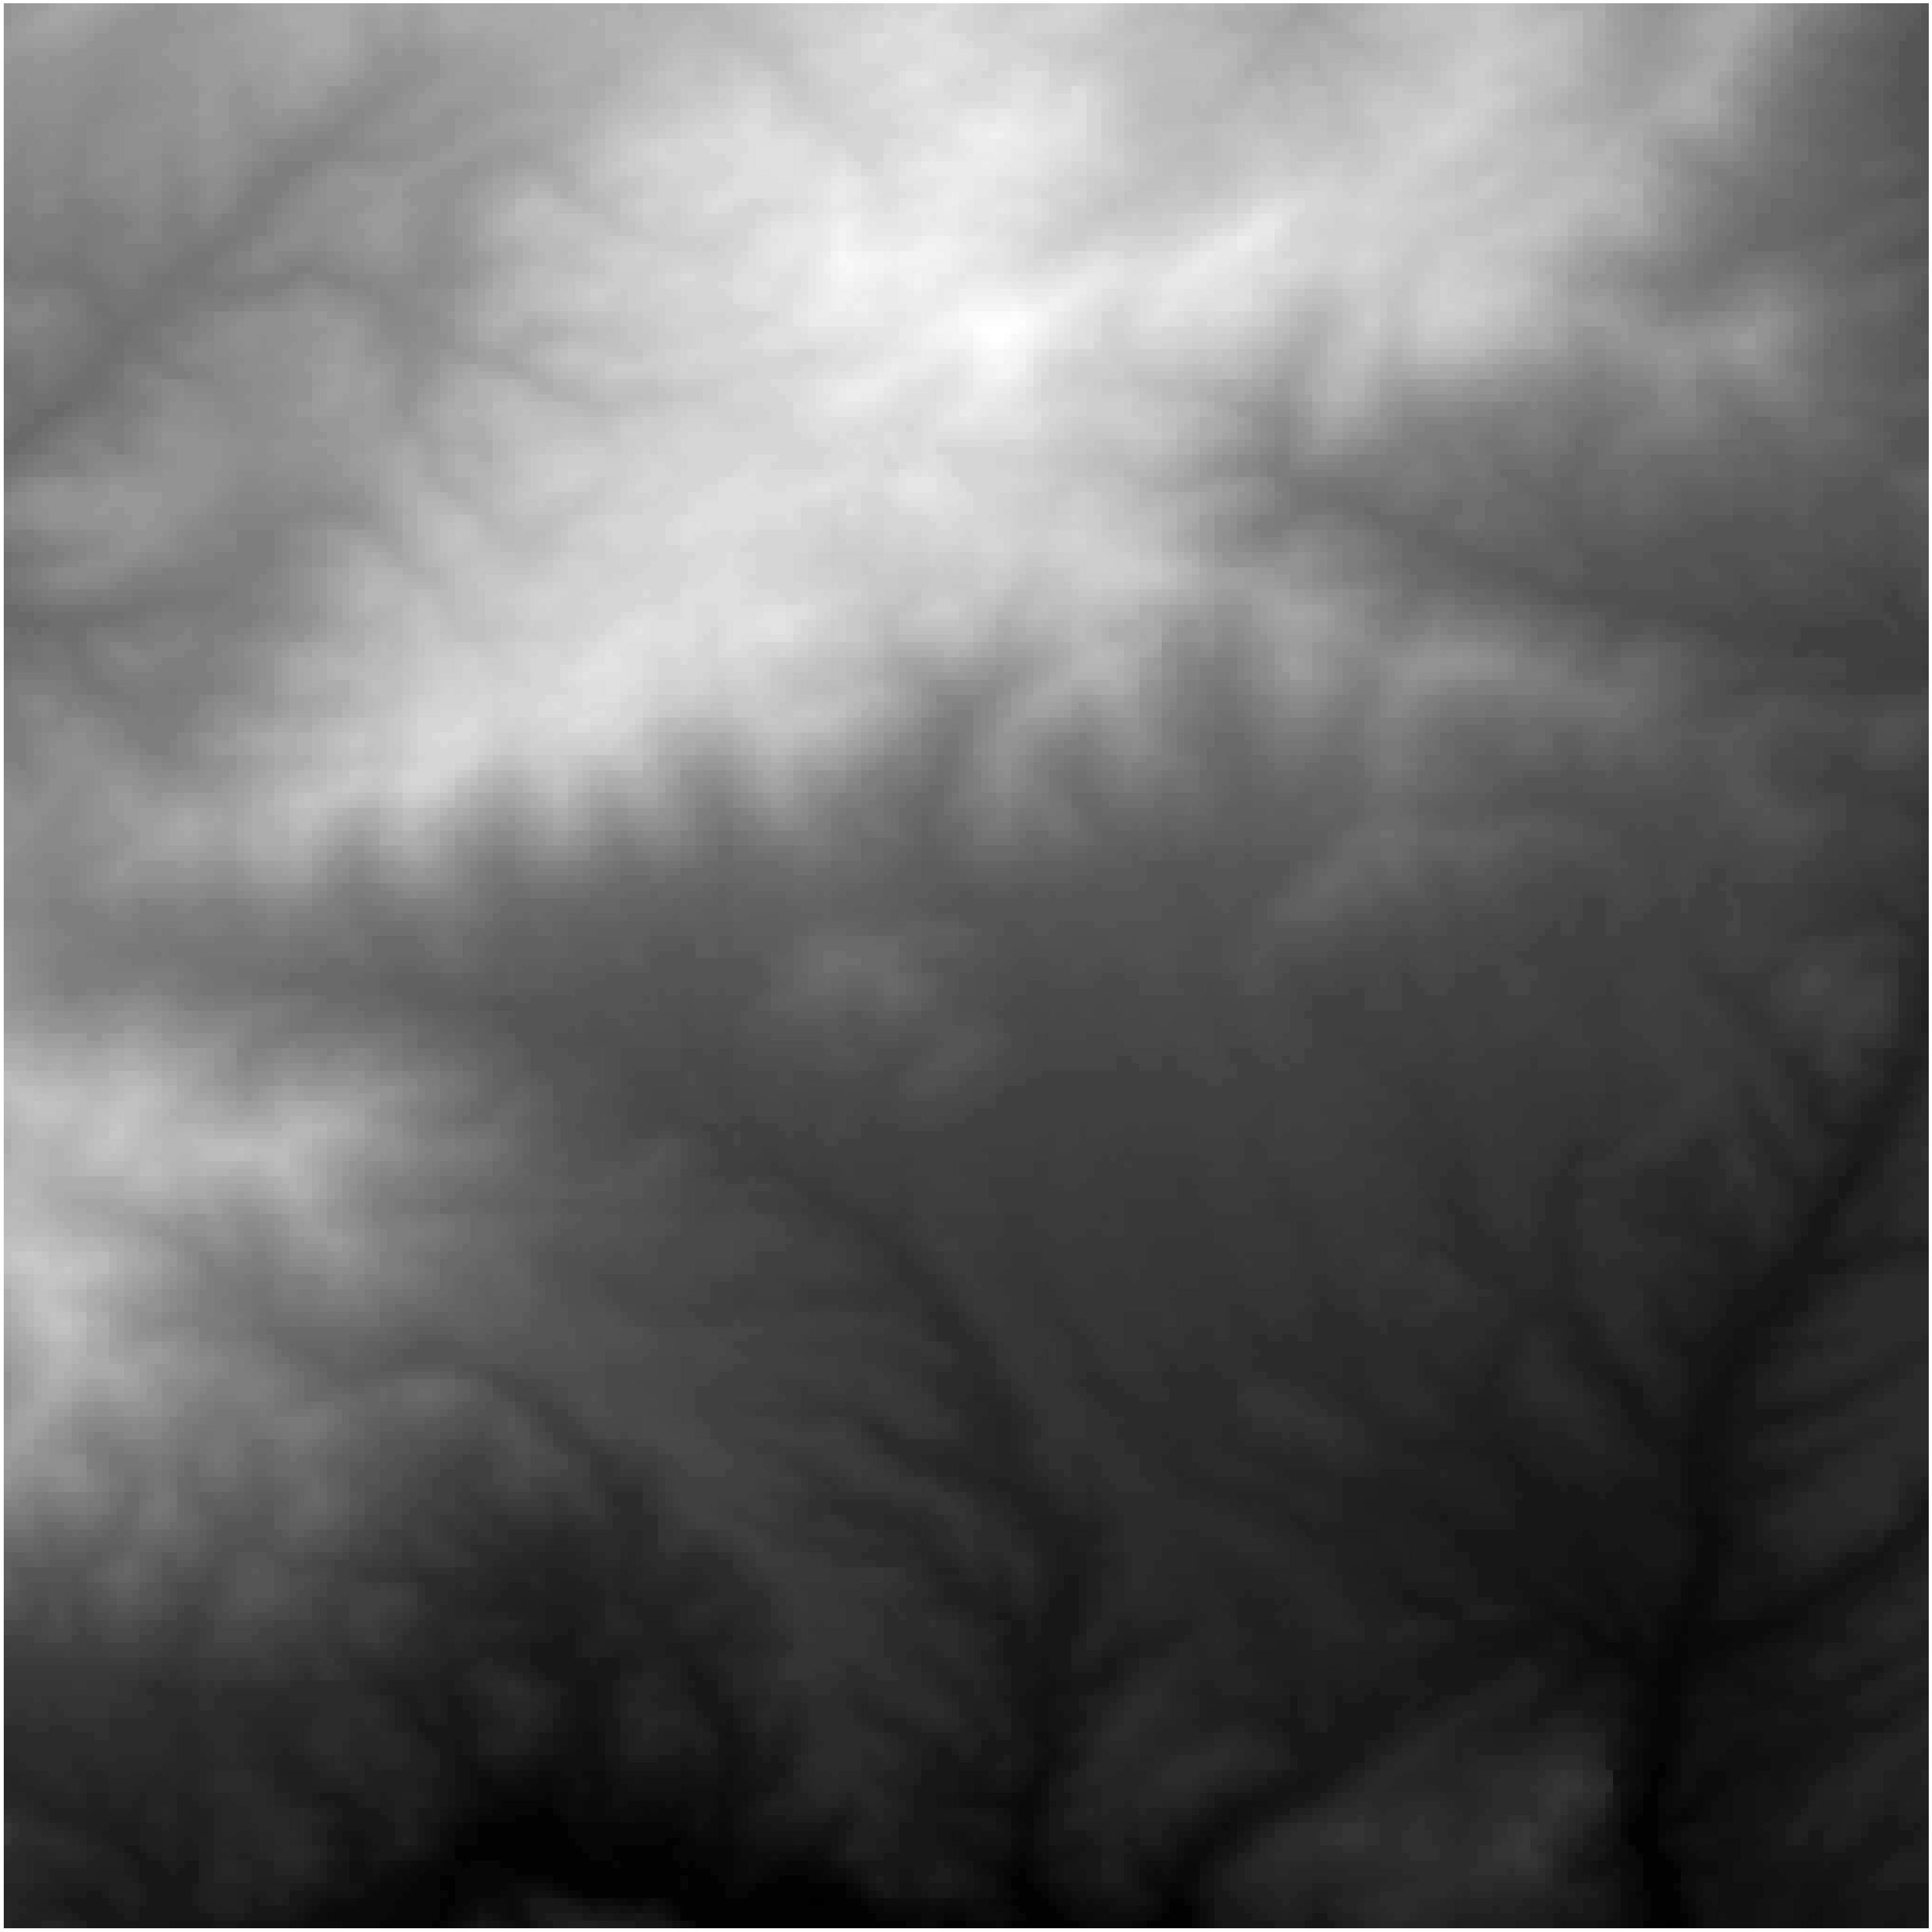

In [9]:
image = image_iterator.next()
image = np.asarray(image[0])
plot_images(image)

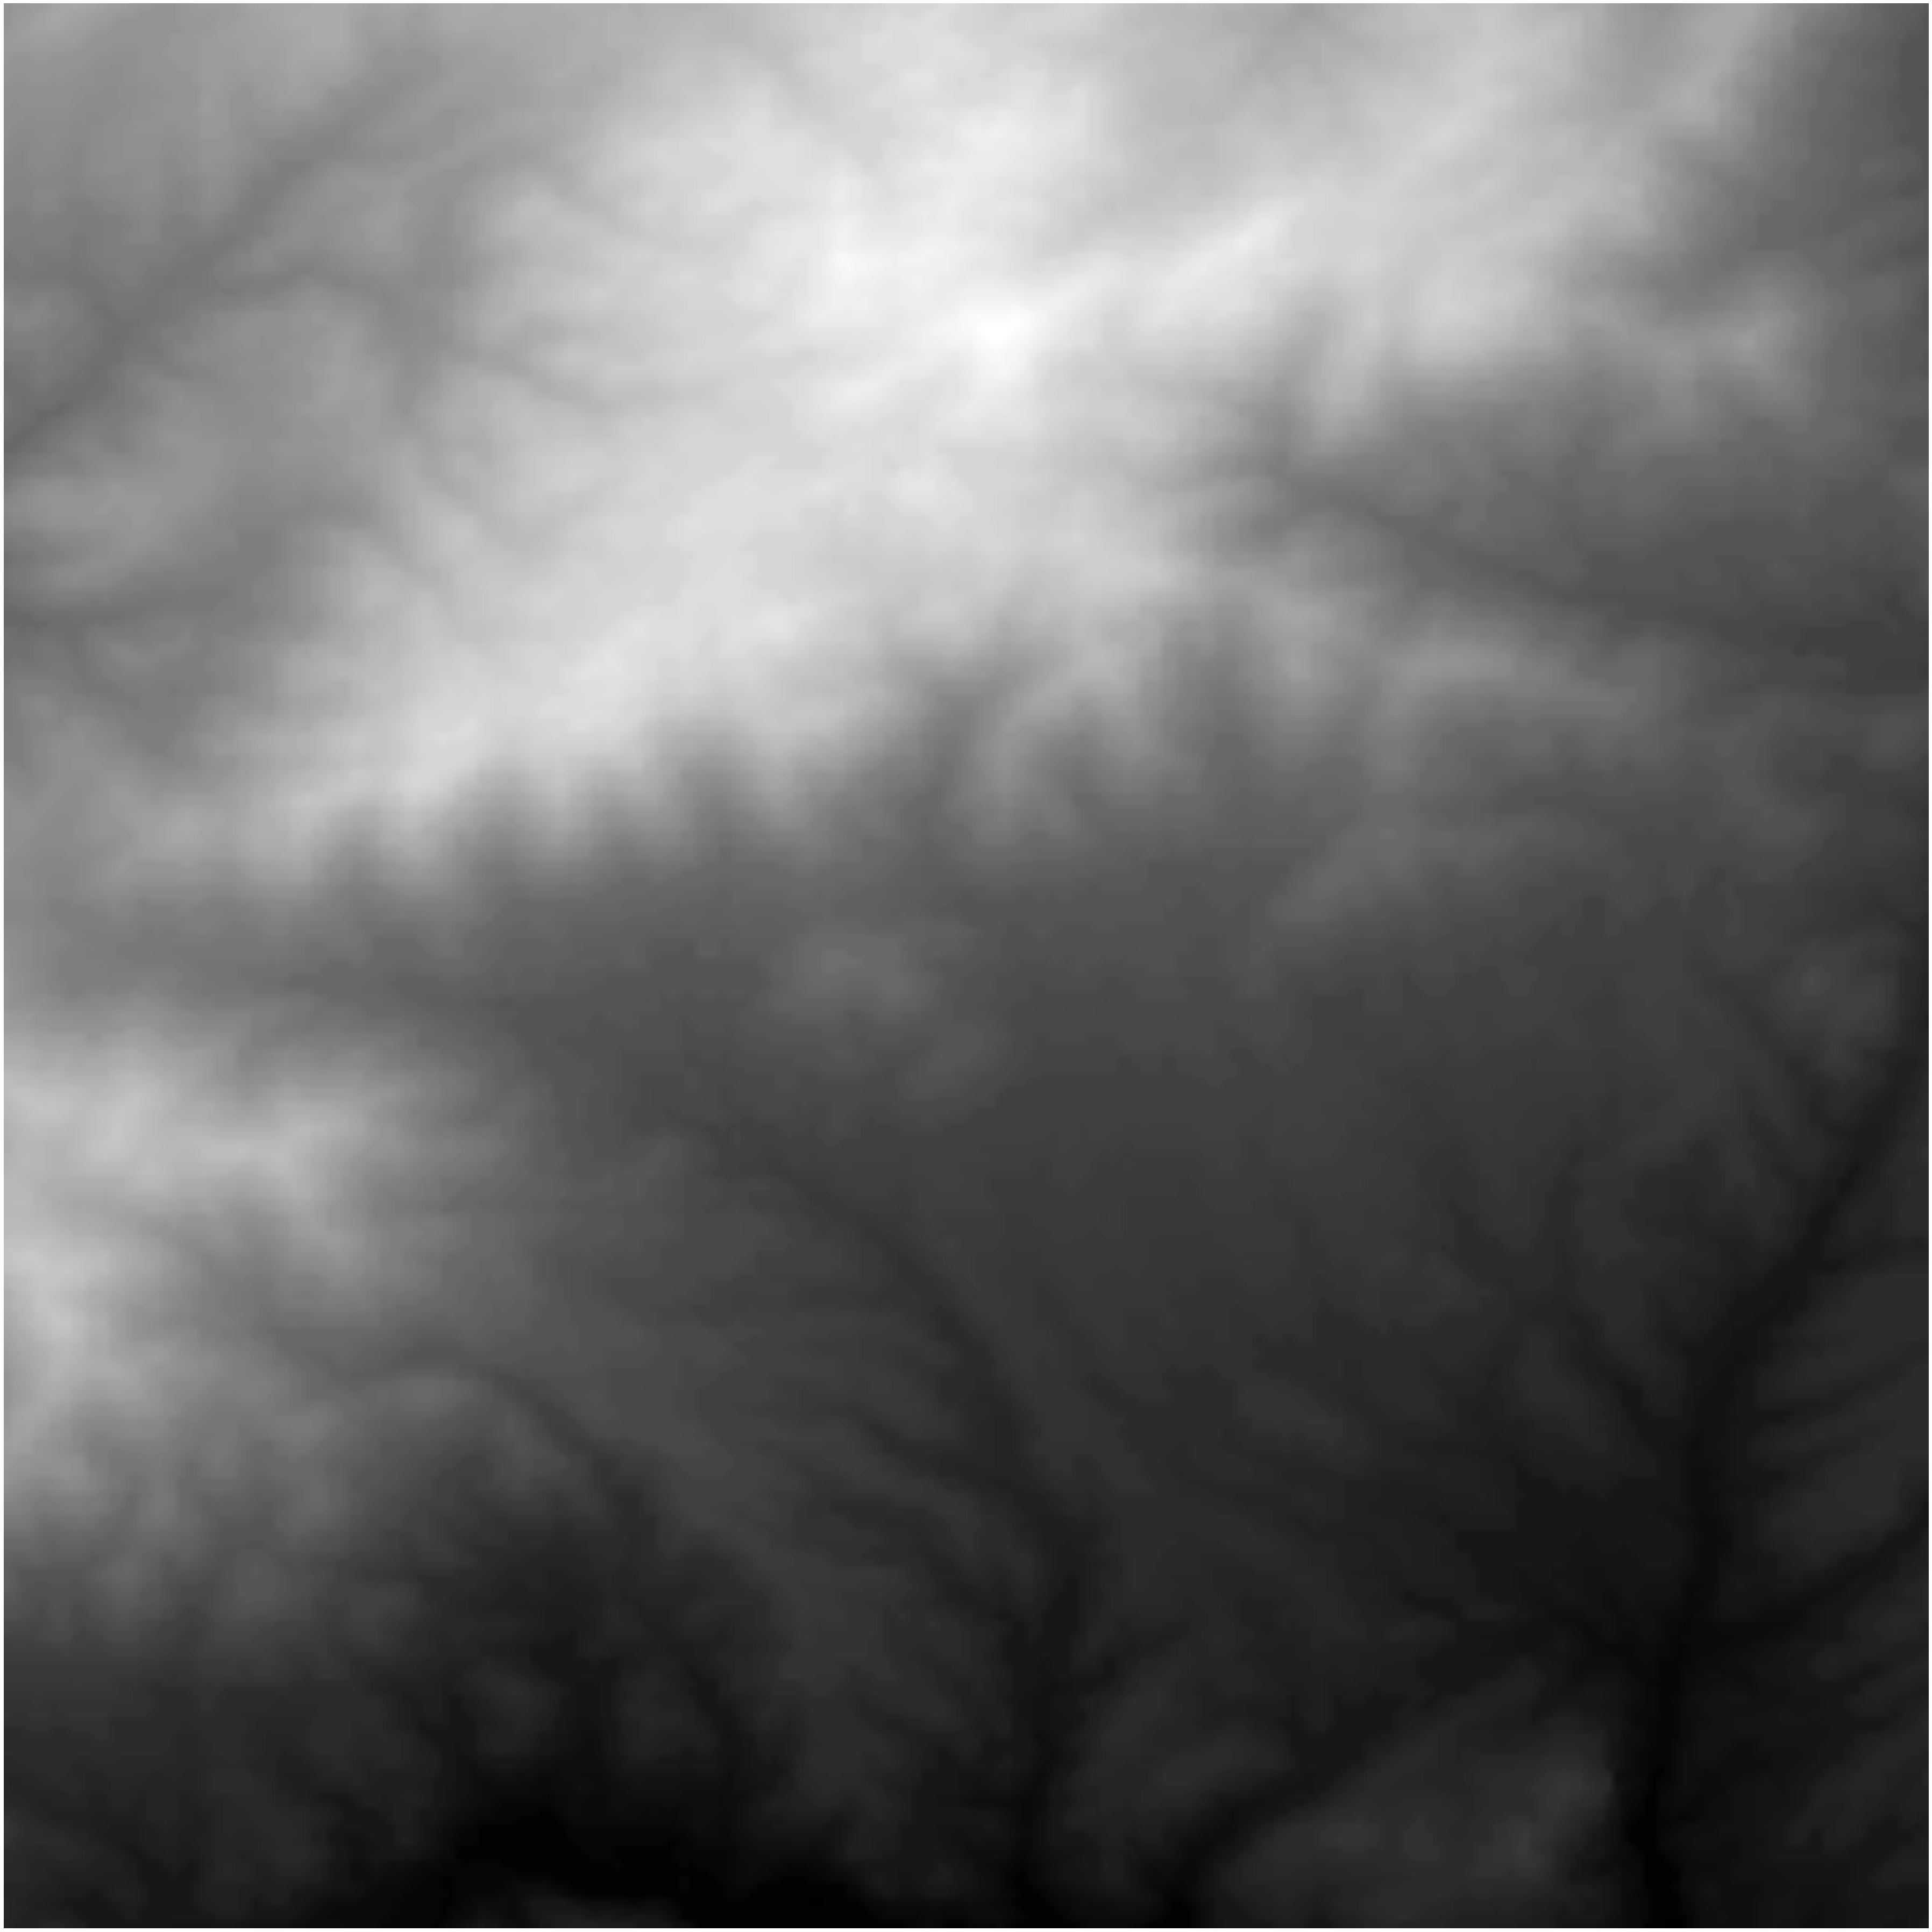

In [10]:
output_image = model(image)
plot_images(output_image)

In [13]:
output_image.shape

TensorShape([1, 2048, 2048, 1])

In [40]:
plt.imsave('../data/heightmap_test3.png', output_image.numpy().reshape(2048, 2048), cmap='gray')

In [81]:
output_image.shape

TensorShape([1, 2048, 2048, 1])

In [11]:
model.save('../data/models/simple_upsampler_bilinear')

INFO:tensorflow:Assets written to: ../data/models/simple_upsampler_bilinear\assets


In [164]:
model2 = keras.models.load_model("../data/models/gaussian_blur_upsampler2")